\***\*============================GRAPH PREPROCESSING============================**


In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from random import randint
import time
import pickle

# Define the Edge class
class Edge:
    def __init__(self, u, v, weight):
        self.u = u
        self.v = v
        self.weight = weight
def preprocess_graph(G):
    # assuming 'weight' is the name of the attribute for edge weights
    return dict(nx.all_pairs_dijkstra_path_length(G, weight='weight'))

In [2]:


# # Read the file and create edges with random weights
# file_path = 'small_dataset.txt'  # Replace with the actual file path
# edges = []
# with open(file_path, 'r') as file:
#     file_contents = file.readlines()
#     num_lines = len(file_contents)
#     for i, line in enumerate(file_contents):
#         node1, node2 = map(int, line.split())
#         weight = float(randint(1, 99)) + (1 / (2 ** (num_lines + i + 1)))
#     # Ensure the weight is displayed with full precision
#         # print(f"Weight: {weight:.50f}")
#         edges.append(Edge(node1, node2, weight))

# # Create a NetworkX graph and add edges
# G = nx.Graph()
# for edge in edges:
#     G.add_edge(edge.u, edge.v, weight=edge.weight)

# # Preprocess the graph
# D = dict(nx.all_pairs_dijkstra_path_length(G, weight='weight'))

# # Create a new figure with a larger size
# plt.figure(figsize=(60, 60))

# # Draw the graph using the spring_layout
# pos = nx.spring_layout(G)
# nx.draw(G, pos, with_labels=True, node_color="yellow", node_size=300, edge_color="gray")

# # Draw edge labels
# edge_labels = nx.get_edge_attributes(G, "weight")
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6)

# plt.show()

In [3]:
# import pickle
# # Store G and D locally using pickle
# with open('graph.pkl', 'wb') as f:
#     pickle.dump(G, f)

# with open('distances.pkl', 'wb') as f:
#     pickle.dump(D, f)
    

In [4]:
# Load G and D from the local files
with open('graph.pkl', 'rb') as f:
    G = pickle.load(f)
with open('distances.pkl', 'rb') as f:
    D = pickle.load(f)
with open('shortest_paths.pkl', 'rb') as f:
    shortest_paths = pickle.load(f) 

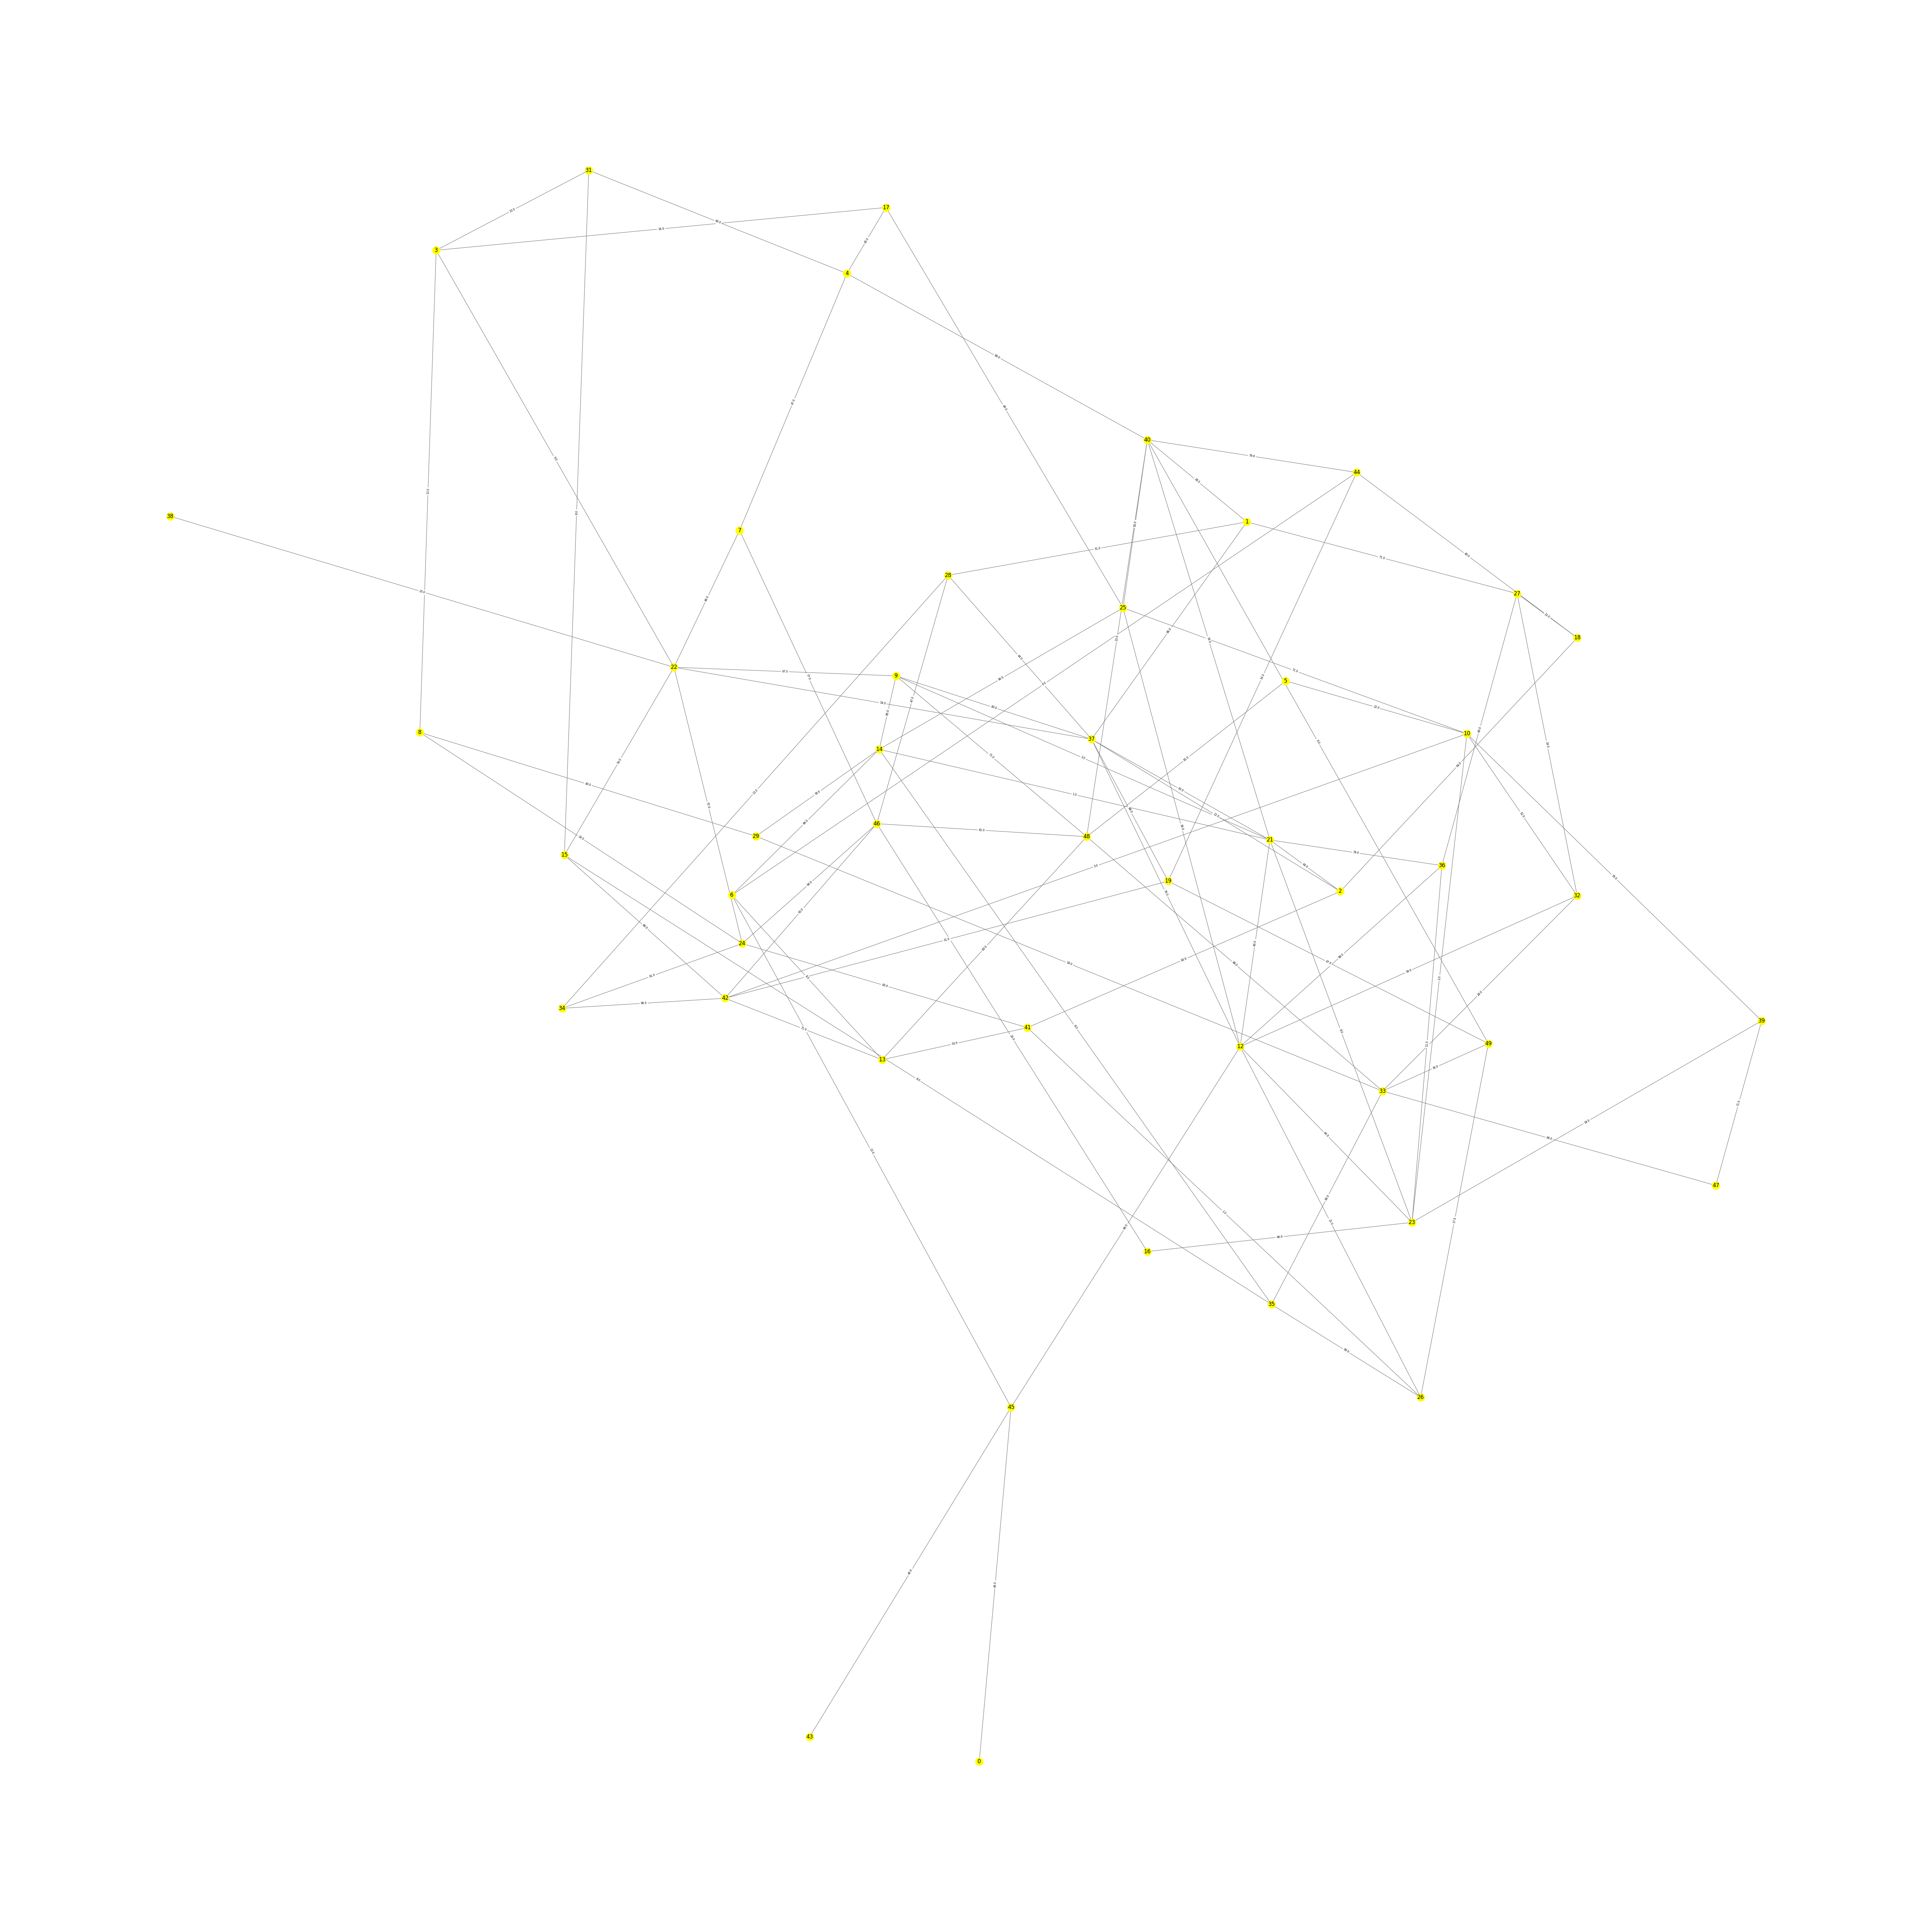

In [5]:
# Create a new figure with a larger size
plt.figure(figsize=(60, 60))

# Draw the graph using the spring_layout
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color="yellow", node_size=300, edge_color="gray")

# Draw edge labels
edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6)

plt.show()

=================================== Distance Oracle =====================================


In [6]:
class DistanceOracle:
    def __init__(self,distances=None):
        if distances is None:
            self.data = {}
        else:
            self.data = distances
    def get_distance(self, u, v):
        return self.data.get(u, {}).get(v, float("inf"))
    def __getitem__(self, key):
        return self.data[key]
    def add_distance(self, u, v, distance):
        if u not in self.data:
            self.data[u] = {}
        self.data[u][v] = distance


In [7]:

distance_oracle = DistanceOracle(D)

\*\*---------------------------------SHORTEST PATH function and Store-------------------------------


In [8]:
# import networkx as nx

# def store_shortest_paths(G):
#     # Use NetworkX's built-in function to compute all pairs shortest paths
#     all_pairs_paths = dict(nx.all_pairs_dijkstra_path(G, weight='weight'))
    
#     # Flatten the dictionary to match the desired output format
#     shortest_paths = {}
#     for u, paths in all_pairs_paths.items():
#         for v, path in paths.items():
#             shortest_paths[(u, v)] = path
    
#     return shortest_paths

# # Example usage
# shortest_paths = store_shortest_paths(G)



In [9]:
# with open('shortest_paths.pkl', 'wb') as f:
#     pickle.dump(shortest_paths, f)

---------------------------------POWER_OF_2 FUNCTION--------------------------------


In [10]:
import math



def nearest_power_of_2(x):
    if x <= 0:
        return 0 # Return 1 for non-positive input
    elif math.isinf(x):
        return float("inf")  # Return infinity for infinite input
    else:
        return 2 ** math.floor(math.log2(x))

--------------------------------FIND_JUMP FUNCTION--------------------------------


In [11]:
def FINDJUMP(P, F):
    X = []  # Initialize X with s
    x = P[0]
    X.append(x)
    # F = list(F)
    # vertices = [F.u , F.v]
   
    if(nearest_power_of_2(
        distance_oracle.get_distance(x, F[0]))< nearest_power_of_2(distance_oracle.get_distance(x, F[1]))):
            u = F[0]
    else:
        u = F[1]
    
    # u = min(F, key=lambda v: nearest_power_of_2(
    #     distance_oracle.get_distance(x, v)))
    # print(u)
    while True:
        # Find y, the first vertex on P[x, t] at distance >= max{1, (xu)^2} from x
        distance = max(1, nearest_power_of_2(
            distance_oracle.get_distance(x, u)))
        # print(distance)
        y = None
        for vertex in P[P.index(x)+1:]:
            if distance_oracle.get_distance(x, vertex) >= distance:
                y = vertex
                break
        if y is not None:
            X.append(y)
            x = y
        else:
            break
    return X

In [12]:
# m = FINDJUMP([13, 6, 3, 7, 11, 19], [6, 3])
# print(m)

**------------------------------MAXIMIZER FUNCTION--------------------------------
**


In [13]:
def get_edge_weight(G, u, v):
    if G.has_edge(u, v):
        return G[u][v].get('weight', float('inf'))  # Provide a default value if 'weight' is missing
    else:
        return float('inf')

In [14]:
 
def maximizer(G, x, y, d1, d2):
    max_edges = set()
    edges_set = set()
    max_xy_edge = None
    max_xy_path = None
    max_xy_path_new = None

    # Cache distance calculations
    distance_cache = {}

    def get_distance_cached(node1, node2):
        if (node1, node2) not in distance_cache:
            distance_cache[(node1, node2)] = distance_oracle.get_distance(node1, node2)
        return distance_cache[(node1, node2)]

    if nx.has_path(G, x, y):
        path = shortest_paths[(x, y)]
        for i in range(len(path) - 1):
            u = path[i]
            v = path[i + 1]
            edges_set.add((u, v))

    for u, v in edges_set:
        if get_distance_cached(x, u) >= d1 and get_distance_cached(y, v) >= d2:
            max_edges.add((u, v))

    max_xy_distance = float('-inf')
    for u, v in max_edges:
        G_copy = G.copy()
        if G_copy.has_edge(u, v):
            G_copy.remove_edge(u, v)
        D = preprocess_graph(G_copy)
        distance_oracle_new = DistanceOracle(D)
        if nx.has_path(G_copy, x, y):
            xy_path = nx.dijkstra_path(G_copy, x, y, weight='weight')
            max_uv_distance = distance_oracle_new.get_distance(x, y)
            if max_uv_distance > max_xy_distance:
                max_xy_edge = (u, v)
                max_xy_path = xy_path
                max_xy_distance = max_uv_distance

    if max_xy_path is not None:
        s = 0
        max_xy_path_new = []
        for i in range(len(max_xy_path) - 1):
            u = max_xy_path[s]
            v = max_xy_path[i + 1]
            uv_distance = get_distance_cached(u, v)
            uv_distance_path = sum(
                get_edge_weight(G, max_xy_path[j], max_xy_path[j + 1])
                for j in range(s, i + 1)
            )
            if uv_distance != uv_distance_path:
                if i < (len(max_xy_path) - 2):
                    s_to_a_path = [u]
                    intermediate_edge = (v, max_xy_path[i + 2])
                    s_to_a_path.append(max_xy_path[i])
                    max_xy_path_new.append(s_to_a_path)
                    max_xy_path_new.append(intermediate_edge)
                    s = i + 2
        max_xy_path_new.append([u, max_xy_path[-1]])

        if len(max_xy_path_new) == 1:
            max_xy_path_new = [max_xy_path]

    return max_xy_edge, max_xy_path_new


In [15]:
maximizer(G, 23, 21, 0, 0)

((23, 21), [[23, 36, 21]])

==============================MAXIMIZER Storage=========================================


In [16]:
def find_max_distance(G, distance_oracle):
    max_distance = float("-inf")
    for key1, value1 in distance_oracle.items():
        for key2, value2 in value1.items():
            if value2 > max_distance:
                max_distance = value2
    return max_distance

In [17]:
max_d_value = int(find_max_distance(G, D))
d1_d2_list = [0]
i = nearest_power_of_2((max_d_value))


while i >= 1:
    d1_d2_list.append(i)
    i //= 2
# print(max_d_value)

In [18]:
# import networkx as nx
# from concurrent.futures import ThreadPoolExecutor, as_completed

# # Initialize a dictionary to store the maximizer output
# maximizer_dict = {}

# # Store the maximizer function reference directly
# maximizer_function = maximizer  # Replace 'maximizer' with the actual function name

# # Collect errors to print after the loop
# errors = []

# # Define a function to process a single pair of nodes
# def process_pair(G, x, y, d1, d2):
#     try:
#         result = maximizer_function(G, x, y, d1, d2)
#         if result is not None:
#             max_edge, max_path = result
#             return (x, y, d1, d2), (max_edge, max_path)
#     except nx.NetworkXNoPath:
#         return (x, y, d1, d2), None

# # Use ThreadPoolExecutor to parallelize the computation
# with ThreadPoolExecutor() as executor:
#     futures = []
#     for x in G.nodes:
#         for y in G.nodes:
#             if x != y:
#                 for d1 in d1_d2_list:
#                     for d2 in d1_d2_list:
#                         futures.append(executor.submit(process_pair, G, x, y, d1, d2))

#     for future in as_completed(futures):
#         key, result = future.result()
#         if result is not None:
#             maximizer_dict[key] = result
#         else:
#             errors.append(f"No path between {key[0]} and {key[1]} for d1: {key[2]}, d2: {key[3]}.")

# # Print all errors after the loop
# for error in errors:
#     print(error)

# # print(maximizer_dict)

In [19]:
# with open('maximizer_dict.pkl', 'wb') as f:
#     pickle.dump(maximizer_dict, f)
    

In [20]:
# load maximizer_dict from the local file   
with open('maximizer_dict.pkl', 'rb') as f:
    maximizer_dict = pickle.load(f)

===============================MAIN: QUERY FUNCTION====================================


In [21]:
def is_valid_path(G, path):
    return all(G.has_edge(path[i], path[i + 1]) for i in range(len(path) - 1)) and (
        len(path) < 2 or G.has_edge(path[-2], path[-1])
    )
def remove_duplicates(lst):
    seen = set()
    result = []
    for item in lst:
        if item not in seen:
            seen.add(item)
            result.append(item)
    return result
def QUERY(s, t, e):
    if e == []:
        try:
            return shortest_paths[(s, t)]
        except KeyError:
            print(f"Shortest path for ({s}, {t}) not found in shortest_paths.")
            return []
        # return shortest_paths[(s, t)]
    # Check if the edge e is in the graph
    if isinstance(e, list):
        e.u, e.v = e
    if not (G.has_edge(e.u, e.v) or G.has_edge(e.v, e.u)):
        # print("The edge to avoid is not in the graph.")
        return shortest_paths[(s, t)]
    if distance_oracle.get_distance(s, e.u) > distance_oracle.get_distance(s, e.v):
        e.u, e.v = e.v, e.u
    # Check if there is a valid path between s and t
    if shortest_paths[(s, t)] is None and shortest_paths[(t, s)] is None:
        print("There is no valid path between the source and destination vertices.")
        return [], float("inf")
    # print(f"shortest_paths[(s,t)]={shortest_paths[(s, t)]}")
    JUMP_st = FINDJUMP(shortest_paths[(s, t)], [e.u, e.v])
    JUMP_ts = FINDJUMP(shortest_paths[(t, s)], [e.u, e.v])
    # print(f"JUMP_st={JUMP_st}, JUMP_ts={JUMP_ts}")
    final_shortest_path = []
    shortest_path_distance = float("inf")
    for x in JUMP_st:
        for y in JUMP_ts:
            if x == y:
                continue
            # print(f"x={x}, y={y}")
            d1 = nearest_power_of_2(distance_oracle.get_distance(x, e.u))
            d2 = nearest_power_of_2(distance_oracle.get_distance(y, e.v))
            # print(f"d1={d1}, d2={d2}")
            e_star, xy_e_star = maximizer_dict[(x, y, d1, d2)]
            # e_star, xy_e_star = maximizer(x, y, d1, d2)
            
            
            # print(f"e_star={e_star}, xy_e_star={xy_e_star}")
            if xy_e_star is None:
                xy_e_star = []
            elif len(xy_e_star)> 2:
                # Flatten the list of lists
                xy_e_star = shortest_paths[(xy_e_star[0][0], xy_e_star[0][1])] + [xy_e_star[1][0]] + shortest_paths[(
                    # print(f"xy_e_star={xy_e_star}")
                    xy_e_star[2][0], xy_e_star[2][1])]
            else: 
                xy_e_star = xy_e_star[0]
            sx_path = shortest_paths[(s, x)]
            yt_path = shortest_paths[(y, t)]
            # print(f"sx_path={sx_path}, yt_path={yt_path}")
            # if sx_path is None or yt_path is None:
            #     continue  # Skip if there is no valid path from s to x or y to t
            if sx_path is None:
                sx_path = [x]
            if yt_path is None:
                yt_path = [y]
            
            p_distance = float("inf")
            P = sx_path + xy_e_star[1:-1] + yt_path
            P = remove_duplicates(sx_path + xy_e_star + yt_path)
            # print(f"P={P}")
            if is_valid_path(G, P):
                p_distance = sum(
                    get_edge_weight(G, P[i], P[i + 1]) for i in range(len(P) - 1)
                )

            p_edges = [(P[i], P[i+1]) for i in range(len(P) - 1)]
            if ((e.u , e.v) not in p_edges and (e.v , e.u) not in p_edges ) and (p_distance < shortest_path_distance):
                    final_shortest_path = P
                    # print(f"shortest_path1={final_shortest_path}")
                    shortest_path_distance = p_distance
    return final_shortest_path

In [22]:
G_copy = G.copy()   
def cross_check(G_copy, s, t, e_u, e_v):
    edge_exists = G_copy.has_edge(e_u, e_v)
    if edge_exists:
        edge_data = G_copy.get_edge_data(e_u, e_v)
        G_copy.remove_edge(e_u, e_v)
        # print(f"Removed edge ({e_u}, {e_v}) from the graph.")
    

    st_path = nx.dijkstra_path(G_copy, s, t, weight='weight')
    
    if edge_exists:
        G_copy.add_edge(e_u, e_v, **edge_data)
        # print(f"Added edge ({e_u}, {e_v}) back to the graph.")



    return st_path

# cross_check(G, 1, 435, 236, 122)

#**-----------------2-fault distance oracle----------------**


##Basic Function


In [23]:
f = 2

In [24]:
def edge_in_path(p, F2):
    if len(p) < 2:
        return False
    p_edges = [(p[i], p[i+ 1]) for i in range(len(p) - 1)]
    for edge in F2:
        if (edge.u ,edge.v) in p_edges or (edge.v , edge.u) in p_edges:
            return True
    return False
def bfs_tree_of_S_rooted_x(graph, s, x):
    # Generate BFS tree rooted at x
    bfs_tree_s = nx.bfs_tree(graph, s)
    # Check if u is in the BFS tree rooted at x
    if x in bfs_tree_s.nodes:
        # Generate BFS tree roted at u from the BFS tree rooted at x
        bfs_tree_x = nx.bfs_tree(bfs_tree_s, x)
        bfs_tree_nodes = list(bfs_tree_x.nodes)
        return bfs_tree_nodes
    else:
        # print(f"Node {x} is not in the BFS tree rooted at {s}")
        return None
def intact_from_failure_path(path, F):
    if path is None:
        return False

    path_edges = [(path[i], path[i + 1]) for i in range(len(path) - 1)]
    # print(f"F: {F}")

    if len(F) == 0:
        return True

    if isinstance(F, list) and len(F) == 2 and all(isinstance(x, int) for x in F):
        if (F[0], F[1]) in path_edges or (F[1], F[0]) in path_edges:
            return False
        return True

    for edge in F:
        if isinstance(edge, tuple):
            if (edge[0], edge[1]) in path_edges or (edge[1], edge[0]) in path_edges:
                return False
        elif isinstance(edge, list):
            if (edge[0], edge[1]) in path_edges or (edge[1], edge[0]) in path_edges:
                return False
        elif hasattr(edge, 'u') and hasattr(edge, 'v'):
            if (edge.u, edge.v) in path_edges or (edge.v, edge.u) in path_edges:
                return False
        else:
            print(f"Unexpected edge type: {type(edge)}")
            return False

    return True
def intact_from_failure_tree(T, F):
    # Check if F is empty
    if T is None:
        # print("bfs_tree_of_S_rooted_x returned None")
        return True
    if not F:
        return True
    
    if isinstance(F, list) and len(F) == 2 and all(isinstance(x, int) for x in F):
        if F[0] in T or F[1] in T:
            return False
        return True

    # Check if any vertex in F is in the tree T
    for edge in F:
        # Unpack edge into u and v
        if isinstance(edge, Edge):
            u, v = edge.u, edge.v
        elif isinstance(edge, tuple) or isinstance(edge, list):
            u, v = edge
        else:
            print(f"Unexpected edge type: {type(edge)}")
            return False

        if u in T or v in T:
            return False

    return True
def single_edge_in_path(p, F2):
    if p is not None:
        p_edges = [(p[i], p[i + 1]) for i in range(len(p) - 1)]
        
        for edge in F2:
            # unpack edge into u and v
            if isinstance(edge, Edge):
                u, v = edge.u, edge.v
            else:
                u,v = edge
            # check if the edge is in the path
            if (u, v) in p_edges or (v, u) in p_edges:
                return True
        return False

In [25]:

F2 = [Edge(6, 3, get_edge_weight(G, 6, 3)), Edge(2, 5, get_edge_weight(G, 2, 5))]
edge_in_path([2,5], F2)
F3 = [Edge(1, 3, get_edge_weight(G, 1, 3)), Edge(17, 9, get_edge_weight(G, 17, 9))]

print(single_edge_in_path([3, 1, 2, 4,9], F3))

True


#Maximizer Functions


In [26]:
# load all maximizer_dict
with open('maximizer_dict1.pkl', 'rb') as f:
    maximizer_dict1 = pickle.load(f)
with open('maximizer_dict21.pkl', 'rb') as f:
    maximizer_dict21 = pickle.load(f)
with open('maximizer_dict2.pkl', 'rb') as f:
    maximizer_dict2 = pickle.load(f)
with open('maximizer_dict3.pkl', 'rb') as f:
    maximizer_dict3 = pickle.load(f)

In [27]:
shortest_paths[(36 ,21)]
G.edges


EdgeView([(0, 45), (45, 6), (45, 12), (45, 43), (1, 37), (1, 40), (1, 27), (1, 28), (37, 2), (37, 9), (37, 12), (37, 19), (37, 21), (37, 22), (37, 28), (40, 4), (40, 21), (40, 25), (40, 48), (40, 49), (40, 44), (27, 18), (27, 32), (27, 36), (28, 34), (28, 46), (2, 18), (2, 41), (2, 21), (18, 44), (41, 13), (41, 24), (41, 26), (21, 9), (21, 12), (21, 14), (21, 23), (21, 36), (3, 8), (3, 31), (3, 17), (3, 22), (8, 24), (8, 29), (31, 4), (31, 15), (17, 4), (17, 25), (22, 7), (22, 9), (22, 15), (22, 24), (22, 38), (4, 7), (7, 46), (5, 10), (5, 48), (10, 42), (10, 23), (10, 25), (10, 32), (10, 39), (48, 9), (48, 13), (48, 33), (48, 46), (6, 44), (6, 14), (6, 13), (44, 19), (14, 9), (14, 29), (14, 25), (14, 35), (13, 42), (46, 16), (46, 24), (46, 42), (24, 34), (29, 33), (42, 15), (42, 19), (42, 34), (23, 12), (23, 16), (23, 36), (23, 39), (25, 12), (32, 12), (32, 33), (39, 47), (12, 26), (12, 36), (26, 35), (26, 49), (35, 15), (35, 33), (19, 49), (49, 33), (33, 47)])

In [28]:



def maximizer1(G, x, y, d1, d2):
    max_edges = set()
    edges_set = set()
    max_xy_edge = None
    max_xy_path = None
    max_xy_distance = float("-inf")
    max_xy_path_new = None
    # xy_distance = distance_oracle.get_distance(x, y)
    # make the set of edges in xy path
    # if nx.has_path(G, x, y):
    #     # Get the path and its length
    #     path = shortest_paths[(x, y)]
    #     # print(path)
    #     for i in range(len(path) - 1):
    #         u = path[i]
    #         v = path[i + 1]
    #         edge = (u, v)
    #         edges_set.add(edge)
    # print(edges_set)
    # check max edges in edge list
    for u, v in G.edges:
        # Check if the distance from x to the edge and y to the edge are at least d1 and d2
        if (
            nx.has_path(G, x, u)
            and nx.has_path(G, y, v)
            and (
                distance_oracle.get_distance(x, u) >= d1
                and distance_oracle.get_distance(y, v) >= d2
            )
            # r (distance_oracle.get_distance(x, u) >= d2
            #     and distance_oracle.get_distance(y, v) >= d1)
        ):
            max_edge1 = (u, v)
            max_edges.add(max_edge1)
    max_edges = list(max_edges)
    # print(max_edges)
    max_edges_2 = []
    if max_edges == []:
        return [], [shortest_paths[(x, y)]]

    # if len(max_edges) == 1:
    #     # max_edges_2.append(max_edges[0][0])
    #     # max_edges_2.append(max_edges[0][1])
    #     for u , v in G.edges:
            
    #         if(distance_oracle.get_distance(x, u) >= d1 and distance_oracle.get_distance(y, v) >= d2)  and u!=max_edges[0][0] and v!=max_edges[0][1] and u!=max_edges[0][1] and v!=max_edges[0][0]:
    #             max_edge1 = (u, v)
    #             max_edges.append(max_edge1)
                    
                    

   
    for i in range(len(max_edges)):
        for j in range(i + 1, len(max_edges)):
            max_edges_2.append((max_edges[i], max_edges[j]))
    # print(max_edges_2)

    # G_copy = G.copy()
    # if isinstance(max_edges_2[0], int):
    #     # max_xy_distance = float("-inf")
    #     if G_copy.has_edge(max_edges_2[0], max_edges_2[1]):
    #         G_copy.remove_edge(max_edges_2[0], max_edges_2[1])
    #         # Calculate the xy path distance
    #     D = preprocess_graph(G_copy)
    #     distance_oracle_new = DistanceOracle(D)
    #     if nx.has_path(G_copy, x, y):
    #         xy_path = nx.dijkstra_path(G_copy, x, y, weight="weight")
    #         # print(xy_path)
    #         max_uv_distance = distance_oracle_new.get_distance(x, y)
    #         # print(f"max_uv_distance:{max_uv_distance}")
    #         if max_uv_distance > max_xy_distance:
    #             max_xy_edge = [max_edges_2[0], max_edges_2[1]]
    #             max_xy_path = xy_path
    #             max_xy_distance = max_uv_distance

    # else:
    
    # print(f"max_edges_2:{max_edges_2}")
    # G_copy = G.copy()
    for e1 in max_edges_2:
        # G_copy = G.copy()
        # # print(f"e:{e1 , e2}")
        # # max_xy_distance = float("-inf")

  
        if G.has_edge(e1[0][0], e1[0][1]) and G.has_edge(e1[1][0], e1[1][1]):
            edge1_data = G.get_edge_data(e1[0][0], e1[0][1])
            edge2_data = G.get_edge_data(e1[1][0], e1[1][1])  
            G.remove_edge(e1[0][0], e1[0][1])
            G.remove_edge(e1[1][0], e1[1][1])

            # Calculate the xy path distance
            D = preprocess_graph(G)
            distance_oracle_new = DistanceOracle(D)
            if nx.has_path(G, x, y):
                xy_path = nx.dijkstra_path(G, x, y, weight="weight")
                # print(xy_path)
                max_uv_distance = distance_oracle_new.get_distance(x, y)
                # print(f"max_uv_distance:{max_uv_distance}")
                if max_uv_distance > max_xy_distance:
                    max_xy_edge = (e1[0], e1[1])
                    max_xy_path = xy_path
                    max_xy_distance = max_uv_distance
            G.add_edge(e1[0][0], e1[0][1], **edge1_data)
            G.add_edge(e1[1][0], e1[1][1], **edge2_data)



    # chandge max_xy_path to 3D-composable form
    if max_xy_path is not None:
        s = 0
        max_xy_path_new = []
        for i in range(len(max_xy_path) - 1):
            u = max_xy_path[s]
            v = max_xy_path[i + 1]
            uv_distance = distance_oracle.get_distance(u, v)
            uv_distance_path = sum(
                get_edge_weight(G, max_xy_path[j], max_xy_path[j + 1])
                for j in range(s, i + 1)
            )
            # print(f"uv_distance:{uv_distance}")
            # print(f"uv_distance_path:{uv_distance_path}")
            # s_to_a_path = [u]
            if uv_distance != uv_distance_path:
                if i < (len(max_xy_path) - 2):
                    s_to_a_path = [u]
                    intermediate_edge = (v, max_xy_path[i + 2])
                    # print(f"intermediate:{intermediate_edge}")
                    # print(f"i:{i}")
                    s_to_a_path.append(max_xy_path[i])
                    max_xy_path_new.append(s_to_a_path)
                    max_xy_path_new.append(intermediate_edge)
                    s = i + 2
        max_xy_path_new.append([u, max_xy_path[len(max_xy_path) - 1]])
        if len(max_xy_path_new) == 1:
            max_xy_path_new = []
            max_xy_path_new.append(max_xy_path)
        if len(max_xy_path_new) == 3:
            max_xy_path_new = []
            max_xy_path_new.append(max_xy_path)
    return max_xy_edge, max_xy_path_new

In [36]:



print(d1_d2_list)
shortest_paths[(23, 21)]
# print(G.nodes)

[0, 128, 64, 32, 16, 8, 4, 2, 1]


[23, 21]

In [37]:
print(G.has_edge(3, 17))

True


In [30]:
maximizer1(G, 23, 21, 0, 0)

(((23, 36), (21, 23)), [[23, 10, 42, 19, 49, 40, 21]])

In [31]:
maximizer1(G, 42, 16, 16, 4)

(((35, 33), (1, 40)), [[42, 10, 23, 16]])

In [140]:
from concurrent.futures import ThreadPoolExecutor, as_completed
import networkx as nx
import threading

# Initialize a dictionary to store the maximizer output
maximizer_dict1 = {}

# Store the maximizer function reference directly
maximizer_function = maximizer1  # Replace 'maximizer1' with the actual function name

# Collect errors to print after the loop
errors = []

# Locks for thread-safe access to shared resources
graph_lock = threading.Lock()
dict_lock = threading.Lock()

# Define a function to process a single pair of nodes
def process_pair(G, x, y, d1, d2):
    try:
        with graph_lock:
            result = maximizer_function(G, x, y, d1, d2)
        if result is not None:
            max_edge, max_path = result
            return (x, y, d1, d2), (max_edge, max_path)
    except nx.NetworkXNoPath:
        return (x, y, d1, d2), None
    except Exception as e:
        return (x, y, d1, d2), f"Error: {str(e)}"

# Use ThreadPoolExecutor to parallelize the computation
with ThreadPoolExecutor() as executor:
    futures = []
    for x in list(G.nodes):  # Convert to list to avoid modification during iteration
        for y in list(G.nodes):  # Convert to list to avoid modification during iteration
            if x != y:
                for d1 in d1_d2_list:
                    for d2 in d1_d2_list:
                        futures.append(executor.submit(process_pair, G, x, y, d1, d2))

    for future in as_completed(futures):
        key, result = future.result()
        with dict_lock:
            if isinstance(result, str):
                errors.append(f"Error for {key}: {result}")
            elif result is not None:
                maximizer_dict1[key] = result
            else:
                errors.append(f"No path between {key[0]} and {key[1]} for d1: {key[2]}, d2: {key[3]}.")

# Print all errors after the loop
for error in errors:
    print(error)

# Optionally print the results
# print(maximizer_dict1)

In [144]:
# print(maximizer_dict1)

In [143]:
print(maximizer_dict1[(23, 21, 0, 0)])

(((8, 29), (40, 48)), [[23, 21]])


In [63]:
# with open('maximizer_dict1.pkl', 'wb') as f:
#     pickle.dump(maximizer_dict1, f) 

In [64]:
# # maximizer1(G, 6, 35, 0, 32)
# print(maximizer_dict1[(6, 35, 0, 32)])
# # maximizer1(3, 2, 0, 0)

In [1]:
maximizer1(G , 36 , 21 ,0 ,0)

NameError: name 'maximizer1' is not defined

In [66]:

def maximizer21(x, y, d1, V, F_star):
    max_edges = set()
    edges_set = set()
    max_xy_edge = None
    
    max_xy_path = None
    max_xy_distance = float("-inf")
    
    max_xy_path_new = None
    # xy_distance = distance_oracle.get_distance(x, y)
    # make the set of edges in xy path
    # if nx.has_path(G, x, y):
    #     # Get the path and it length
    #     path = shortest_paths[(x, y)]
    #     # print(path)
    #     for i in range(len(path) - 1):
    #         u = path[i]
    #         v = path[i +1]
    #         edge = (u, v)
    #         edges_set.add(edge)
    # print(edges_set)
    # check max edges i edge list
    for u, v in G.edges:
        # Check if the distance from x to the edge and y to the edge are at least d1 and d2
        if (
            nx.has_path(G, x, u)
            and nx.has_path(G, y, v)
            and (
                distance_oracle.get_distance(x, v) >= d1 or distance_oracle.get_distance(x, u) >= d1
                and intact_from_failure_path(shortest_paths[(V, y)], F_star)
                and intact_from_failure_tree(bfs_tree_of_S_rooted_x(G, y, V), F_star)
            )
            
        ):
            max_edge1 = (u, v)
            max_edges.add(max_edge1)
        # print(max_edges)
    max_edges = list(max_edges)
    # print(max_edges)
    max_edges_2 = []
    if  max_edges==[]:
        return [],[shortest_paths[(x, y)]] 
    
    # if len(max_edges) == 1:
    #     # max_edges_2.append(max_edges[0][0]) 
    #     # max_edges_2.append(max_edges[0][1])
    #     for u  , v in G.edges:
    #         if (
    #             nx.has_path(G, x, u)
    #             and nx.has_path(G, y, v)
    #             and (
    #                 distance_oracle.get_distance(x, v) >= d1 or distance_oracle.get_distance(x, u) >= d1
    #                 and intact_from_failure_path(shortest_paths[(V, y)], F_star)
    #                 and intact_from_failure_tree(bfs_tree_of_S_rooted_x(G, y, V), F_star)
    #             ) and u!=max_edges[0][0] and v!=max_edges[0][1] and u!=max_edges[0][1] and v!=max_edges[0][0]
                
    #         ):
    #             max_edge1 = (u, v)
    #             max_edges.append(max_edge1)       
    # else:
    for i in range(len(max_edges)):
        for j in range(i + 1, len(max_edges)):
            max_edges_2.append((max_edges[i], max_edges[j]))
# print(max_edges_2)

    G_copy = G.copy()
    # if isinstance(max_edges_2[0], int):
    #     # max_xy_distance = float("-inf")
    #     if G_copy.has_edge(max_edges_2[0], max_edges_2[1]):
    #        G_copy.remove_edge(max_edges_2[0], max_edges_2[1])
    #         # Calculate the xy path distance
    #     D = preprocess_graph(G_copy)
    #     distance_oracle_new = DistanceOracle(D)
    #     if nx.has_path(G_copy, x, y):
    #         xy_path = nx.dijkstra_path(G_copy, x, y, weight="weight")
    #         # print(xy_path)
    #         max_uv_distance = distance_oracle_new.get_distance(x, y)
    #         # print(f"max_uv_distance:{max_uv_distance}")
    #         if max_uv_distance > max_xy_distance:
    #             max_xy_edge = [max_edges_2[0], max_edges_2[1]]
    #             max_xy_path = xy_path
    #             max_xy_distance = max_uv_distance
        
        
    # else:
        # G_copy = G.copy()
    for e1 in max_edges_2:
        G_copy = G.copy()
    # print(f"e:{e1 , e2}")
        # max_xy_distance = float("-inf")

        if G_copy.has_edge(e1[0][0], e1[0][1]) and G_copy.has_edge(e1[1][0], e1[1][1]):
            G_copy.remove_edge(e1[0][0], e1[0][1])
            G_copy.remove_edge(e1[1][0], e1[1][1])

# Calculate the xy path distance
        D = preprocess_graph(G_copy)
        distance_oracle_new = DistanceOracle(D)
        if nx.has_path(G_copy, x, y):
            xy_path = nx.dijkstra_path(G_copy, x, y, weight="weight")
            # print(xy_path)
            max_uv_distance = distance_oracle_new.get_distance(x, y)
            # print(f"max_uv_distance:{max_uv_distance}")
            if max_uv_distance > max_xy_distance:
                max_xy_edge = (e1[0], e1[1])
                max_xy_path = xy_path
                max_xy_distance = max_uv_distance

    # chandge max_xy_path to 3D-composable form
    if max_xy_path is not None:
        s = 0
        max_xy_path_new = []
        for i in range(len(max_xy_path) - 1):
            u = max_xy_path[s]
            v = max_xy_path[i +1]
            uv_distance = distance_oracle.get_distance(u, v)
            uv_distance_path = sum(
                get_edge_weight(G, max_xy_path[j], max_xy_path[j + 1])
                for j in range(s, i + 1)
            )
            # print(f"uv_distance:{uv_distance}")
            # print(f"uv_distance_path:{uv_distance_path}")
            # s_to_a_path = [u]
            if uv_distance != uv_distance_path:
                if i < (len(max_xy_path) - 2):
                    s_to_a_path = [u]
                    intermediate_edge = (v, max_xy_path[i + 2])
                    # print(f"intermediate:{intermediate_edge}")
                    # print(f"i:{i}")
                    s_to_a_path.append(max_xy_path[i])
                    max_xy_path_new.append(s_to_a_path)
                    max_xy_path_new.append(intermediate_edge)
                    s = i + 2
        max_xy_path_new.append([u, max_xy_path[len(max_xy_path) - 1]])
        if len(max_xy_path_new) == 1:
            max_xy_path_new = []
            max_xy_path_new.append(max_xy_path)
        if len(max_xy_path_new) == 3:
            max_xy_path_new = []
            max_xy_path_new.append(max_xy_path)
    return max_xy_edge, max_xy_path_new



In [67]:
# from concurrent.futures import ThreadPoolExecutor, as_completed

# # Initialize a dictionary to store the maximizer output
# maximizer_dict21 = {}

# # Store the maximizer function reference directly
# maximizer_function = maximizer21  # Replace 'maximizer' with the actual function name

# # Collect errors to print after the loop
# errors = []

# # Define a function to process a single pair of nodes
# def process_pair(x, y, d1, v, F_star):
#     try:
#         result = maximizer_function(x, y, d1, v, F_star)
#         if result is not None:
#             max_edge, max_path = result
#             return (x, y, d1, v, tuple(F_star)), (max_edge, max_path)
#     except nx.NetworkXNoPath:
#         return (x, y, d1, v, tuple(F_star)), None

# # Use ThreadPoolExecutor to parallelize the computation
# with ThreadPoolExecutor() as executor:
#     futures = []
#     for x in G.nodes:
#         for y in G.nodes:
#             if x != y:
#                 for d1 in d1_d2_list:
#                     for d2 in d1_d2_list:
#                         F_star, xy_f_star = maximizer_dict1[(x, y, d1, d2)]
#                         F_star_vertex = []

#                         if F_star is not None and F_star != []:
#                             if not isinstance(F_star, list):
#                                 F_star = list(F_star)
#                             if isinstance(F_star[0], int):
#                                 F_star_vertex = [F_star[0], F_star[1]]
#                             else:
#                                 F_star_vertex = [vertex for E in F_star for vertex in E]
#                         for v in F_star_vertex:
#                             futures.append(
#                                 executor.submit(process_pair, x, y, d1, v, F_star)
#                             )

#     for future in as_completed(futures):
#         key, result = future.result()
#         if result is not None:
#             maximizer_dict21[key] = result
#         else:
#             errors.append(
#                 f"No path between {key[0]} and {key[1]} for d1: {key[2]}, d2: {key[3]}."
#             )

# # Print all errors after the loop
# for error in errors:
#     print(error)

# # print(maximizer_dict21)

In [68]:
# with open('maximizer_dict21.pkl', 'wb') as f:
#     pickle.dump(maximizer_dict21, f)

In [69]:

def maximizer2(x, y, V, d2, F_star):
    max_edges = set()
    edges_set = set()
    max_xy_edge = None
    max_xy_path = None
    max_xy_distance = float("-inf")
    
    max_xy_path_new = None
    # xy_distance = distance_oracle.get_distance(x, y)
    # make the set of edges in xy path
    # if nx.has_path(G, x, y):
    #     # Get the path and it length
    #     path = shortest_paths[(x, y)]
    #     # print(path)
    #     for i in range(len(path) - 1):
    #         u = path[i]
    #         v = path[i +1]
    #         edge = (u, v)
    #         edges_set.add(edge)
    # print(edges_set)
    # check max edges i edge list
    for u, v in G.edges:
        # Check if the distance from x to the edge and y to the edge are at least d1 and d2
        if (
            nx.has_path(G, x, u)
            and nx.has_path(G, y, v)
            and (
                distance_oracle.get_distance(y, u) >= d2 or distance_oracle.get_distance(v, y) >= d2
                
                 
                
                and intact_from_failure_path(shortest_paths[(x , V)], F_star)
                and intact_from_failure_tree(bfs_tree_of_S_rooted_x(G, x,V), F_star)
            ) 
        ):
            max_edge1 = (u, v)
            max_edges.add(max_edge1)
        # print(max_edges)
    max_edges = list(max_edges)
    # print(max_edges)
    max_edges_2 = []
    if  max_edges==[]:
        return [],[shortest_paths[(x, y)]] 
    
    # if len(max_edges) == 1:
    #     # max_edges_2.append(max_edges[0][0]) 
    #     # max_edges_2.append(max_edges[0][1])
    #     for u, v in G.edges:    
    #         if(nx.has_path(G, x, u)
    #             and nx.has_path(G, y, v)
    #             and (
    #                 distance_oracle.get_distance(y, u) >= d2 or distance_oracle.get_distance(v, y) >= d2
                    
                    
                    
    #                 and intact_from_failure_path(shortest_paths[(x , V)], F_star)
    #                 and intact_from_failure_tree(bfs_tree_of_S_rooted_x(G, x,V), F_star)
    #             )  and u!=max_edges[0][0] and v!=max_edges[0][1] and u!=max_edges[0][1] and v!=max_edges[0][0]
    #             ):
    #             max_edge1 = (u, v)
    #             max_edges.append(max_edge1)
            
    # else:
    for i in range(len(max_edges)):
        for j in range(i + 1, len(max_edges)):
            max_edges_2.append((max_edges[i], max_edges[j]))
    # print(max_edges_2)

    # G_copy = G.copy()
    # if isinstance(max_edges_2[0], int):
    #     # max_xy_distance = float("-inf")
    #     if G_copy.has_edge(max_edges_2[0], max_edges_2[1]):
    #        G_copy.remove_edge(max_edges_2[0], max_edges_2[1])
    #         # Calculate the xy path distance
    #     D = preprocess_graph(G_copy)
    #     distance_oracle_new = DistanceOracle(D)
    #     if nx.has_path(G_copy, x, y):
    #         xy_path = nx.dijkstra_path(G_copy, x, y, weight="weight")
    #         # print(xy_path)
    #         max_uv_distance = distance_oracle_new.get_distance(x, y)
    #         # print(f"max_uv_distance:{max_uv_distance}")
    #         if max_uv_distance > max_xy_distance:
    #             max_xy_edge = [max_edges_2[0], max_edges_2[1]]
    #             max_xy_path = xy_path
    #             max_xy_distance = max_uv_distance
        
        
    # else:
    G_copy = G.copy()
    for e1 in max_edges_2:
        G_copy = G.copy()
    # print(f"e:{e1 , e2}")
        # max_xy_distance = float("-inf")

        if G_copy.has_edge(e1[0][0], e1[0][1]) and G_copy.has_edge(e1[1][0], e1[1][1]):
            G_copy.remove_edge(e1[0][0], e1[0][1])
            G_copy.remove_edge(e1[1][0], e1[1][1])

# Calculate the xy path distance
        D = preprocess_graph(G_copy)
        distance_oracle_new = DistanceOracle(D)
        if nx.has_path(G_copy, x, y):
            xy_path = nx.dijkstra_path(G_copy, x, y, weight="weight")
            # print(xy_path)
            max_uv_distance = distance_oracle_new.get_distance(x, y)
            # print(f"max_uv_distance:{max_uv_distance}")
            if max_uv_distance > max_xy_distance:
                max_xy_edge = (e1[0], e1[1])
                max_xy_path = xy_path
                max_xy_distance = max_uv_distance


    # print(max_xy_path)
# chandge max_xy_path to 3D-composable form
    if max_xy_path is not None:
        s = 0
        max_xy_path_new = []
        for i in range(len(max_xy_path) - 1):
            u = max_xy_path[s]
            v = max_xy_path[i +1]
            uv_distance = distance_oracle.get_distance(u, v)
            uv_distance_path = sum(
                get_edge_weight(G, max_xy_path[j], max_xy_path[j + 1])
                for j in range(s, i + 1)
            )
            # print(f"uv_distance:{uv_distance}")
            # print(f"uv_distance_path:{uv_distance_path}")
            # s_to_a_path = [u]
            if uv_distance != uv_distance_path:
                if i < (len(max_xy_path) - 2):
                    s_to_a_path = [u]
                    intermediate_edge = (v, max_xy_path[i + 2])
                    # print(f"intermediate:{intermediate_edge}")
                    # print(f"i:{i}")
                    s_to_a_path.append(max_xy_path[i])
                    max_xy_path_new.append(s_to_a_path)
                    max_xy_path_new.append(intermediate_edge)
                    s = i + 2
        max_xy_path_new.append([u, max_xy_path[len(max_xy_path) - 1]])
        if len(max_xy_path_new) == 1:
            max_xy_path_new = []
            max_xy_path_new.append(max_xy_path)
        if len(max_xy_path_new) == 3:
            max_xy_path_new = []
            max_xy_path_new.append(max_xy_path)
    return max_xy_edge, max_xy_path_new


In [70]:

# from concurrent.futures import ThreadPoolExecutor, as_completed

# # Initialize a dictionary to store the maximizer output


# maximizer_dict2 = {}

# # Store the maximizer function reference directly
# maximizer_function = maximizer2  # Replace 'maximizer' with the actual function name

# # Collect errors to print after the loop
# errors = []

# # Define a function to process a single pair of nodes
# def process_pair( x, y, v, d2 , F_star):
#     try:
#         result = maximizer_function( x, y, v, d2 , F_star)
#         if result is not None:
#             max_edge, max_path = result
#             return (x, y, v, d2 , tuple(F_star)), (max_edge, max_path)
#     except nx.NetworkXNoPath:
#         return (x, y, v, v ,d2 , tuple(F_star)), None

# # Use ThreadPoolExecutor to parallelize the computation
# with ThreadPoolExecutor() as executor:
#     futures = []
#     for x in G.nodes:
#         for y in G.nodes:
#             if x != y:
#                 for d1 in d1_d2_list:
#                     for d2 in d1_d2_list:
#                         F_star, xy_f_star = maximizer_dict1[(x, y, d1, d2)]
#                         F_star_vertex = []

#                         if F_star is not None and F_star != []:
#                             if F_star is not isinstance(F_star, list):
#                                 F_star = list(F_star)
#                             if isinstance(F_star[0], int):
#                                 F_star_vertex = [F_star[0], F_star[1]]

#                             else:
#                                 F_star_vertex = [vertex for E in F_star for vertex in E]
#                         for v in F_star_vertex:                        
#                             futures.append(executor.submit(process_pair,  x, y, v, d2 , F_star))

#     for future in as_completed(futures):
#         key, result = future.result()
#         if result is not None:
#             maximizer_dict2[key] = result
#         else:
#             errors.append(f"No path between {key[0]} and {key[1]} for d1: {key[2]}, d2: {key[3]}.")

# # Print all errors after the loop
# for error in errors:
#     print(error)

# # print(maximizer_dict)

In [71]:
# with open('maximizer_dict2.pkl', 'wb') as f:
#     pickle.dump(maximizer_dict2, f)

In [72]:
# maximizer2(6, 19, 0, 5, [Edge(6, 3, get_edge_weight(G, 6, 3)),
#       Edge(2, 5, get_edge_weight(G, 2, 5))])

# maximizer21(13, 19, 4, 6, [Edge(6, 3, get_edge_weight(G, 6, 3)),
#       Edge(2, 5, get_edge_weight(G, 2, 5))])

In [97]:

def maximizer3(x, y, u, v, F_star):
    max_edges = set()
    edges_set = set()
    max_xy_edge = None
    max_xy_path = None
    max_xy_distance = float("-inf")
    
    max_xy_path_new = []
    # xy_distance = distanc_oracle.get_distance(x, y)
    # make the set of edges in xy path
    # if nx.has_path(G, x, y):
    #     # Get the path and it length
    #     path = shortest_paths[(x, y)]
    #     # print(path)
    #     for i in range(len(path) - 1):
    #         u = path[i]
    #         v = path[i +1]
    #         edge = (u, v)
    #         edges_set.add(edge)
    # print(edges_set)
    # check max edges i edge list
    for u, v in G.edges:    
        # Check if the distance from x to the edge and y to the edge are at least d1 and d2
        if (
            nx.has_path(G, x, u)
            and nx.has_path(G, y,v)
            and intact_from_failure_path(shortest_paths[(x, u)], F_star)
            and intact_from_failure_tree(bfs_tree_of_S_rooted_x(G, x, u), F_star)
            and intact_from_failure_path(shortest_paths[(v,y)], F_star)
            and intact_from_failure_tree(bfs_tree_of_S_rooted_x(G, y, v), F_star)
        ):
            max_edge1 = (u, v)
            max_edges.add(max_edge1)
    max_edges = list(max_edges)
    # print(max_edges)
    max_edges_2 = []
    if  max_edges==[]:
        return [],[shortest_paths[(x, y)]] 
    
    # if len(max_edges) == 1:
    #     # max_edges_2.append(max_edges[0][0]) 
    #     # max_edges_2.append(max_edges[0][1])
    #     for u , v in G.edges:
    #         if (
    #             nx.has_path(G, x, u)
    #             and nx.has_path(G, y,v)
    #             and intact_from_failure_path(shortest_paths[(x, u)], F_star)
    #             and intact_from_failure_tree(bfs_tree_of_S_rooted_x(G, x, u), F_star)
    #             and intact_from_failure_path(shortest_paths[(v,y)], F_star)
    #             and intact_from_failure_tree(bfs_tree_of_S_rooted_x(G, y, v), F_star) 
    #             and u!=max_edges[0][0] and v!=max_edges[0][1] and u!=max_edges[0][1] and v!=max_edges[0][0]
    #         ):
    #             max_edge1 = (u, v)
    #             max_edges.append(max_edge1)
        
        
    # else:
    for i in range(len(max_edges)):
        for j in range(i + 1, len(max_edges)):
            max_edges_2.append((max_edges[i], max_edges[j]))
    # print(max_edges_2)

    # G_copy = G.copy()
    # if isinstance(max_edges_2[0], int):
    #     # max_xy_distance = float("-inf")
    #     if G_copy.has_edge(max_edges_2[0], max_edges_2[1]):
    #        G_copy.remove_edge(max_edges_2[0], max_edges_2[1])
    #         # Calculate the xy path distance
    #     D = preprocess_graph(G_copy)
    #     distance_oracle_new = DistanceOracle(D)
    #     if nx.has_path(G_copy, x, y):
    #         xy_path = nx.dijkstra_path(G_copy, x, y, weight="weight")
    #         # print(xy_path)
    #         max_uv_distance = distance_oracle_new.get_distance(x, y)
    #         # print(f"max_uv_distance:{max_uv_distance}")
    #         if max_uv_distance > max_xy_distance:
    #             max_xy_edge = [max_edges_2[0], max_edges_2[1]]
    #             max_xy_path = xy_path
    #             max_xy_distance = max_uv_distance
        
        
    # else:
    G_copy = G.copy()
    for e1 in max_edges_2:
        G_copy = G.copy()
    # print(f"e:{e1 , e2}")
        # max_xy_distance = float("-inf")

        if G_copy.has_edge(e1[0][0], e1[0][1]) and G_copy.has_edge(e1[1][0], e1[1][1]):
            G_copy.remove_edge(e1[0][0], e1[0][1])
            G_copy.remove_edge(e1[1][0], e1[1][1])

# Calculate the xy path distance
        D = preprocess_graph(G_copy)
        distance_oracle_new = DistanceOracle(D)
        if nx.has_path(G_copy, x, y):
            xy_path = nx.dijkstra_path(G_copy, x, y, weight="weight")
            # print(xy_path)
            max_uv_distance = distance_oracle_new.get_distance(x, y)
            # print(f"max_uv_distance:{max_uv_distance}")
            if max_uv_distance > max_xy_distance:
                max_xy_edge = (e1[0], e1[1])
                max_xy_path = xy_path
                max_xy_distance = max_uv_distance


    # print(max_xy_path)
# chandge max_xy_path to 3D-composable form
    if max_xy_path is not None:
        s = 0
        # max_xy_path_new = []
        for i in range(len(max_xy_path) - 1):
            u = max_xy_path[s]
            v = max_xy_path[i +1]
            uv_distance = distance_oracle.get_distance(u, v)
            uv_distance_path = sum(
                get_edge_weight(G, max_xy_path[j], max_xy_path[j + 1])
                for j in range(s, i + 1)
            )
            # print(f"uv_distance:{uv_distance}")
            # print(f"uv_distance_path:{uv_distanc_path}")
            # s_to_a_path = [u]
            if uv_distance != uv_distance_path:
                if i < (len(max_xy_path) - 2):
                    s_to_a_path = [u]
                    intermediate_edge = (v, max_xy_path[i + 2])
                    # print(f"intermediate:{intermediate_edge}")
                    # print(f"i:{i}")
                    s_to_a_path.append(max_xy_path[i])
                    max_xy_path_new.append(s_to_a_path)
                    max_xy_path_new.append(intermediate_edge)
                    s = i + 2
        max_xy_path_new.append([u, max_xy_path[len(max_xy_path) - 1]])   
        if len(max_xy_path_new) == 1:
            max_xy_path_new = []
            max_xy_path_new.append(max_xy_path)
        if len(max_xy_path_new) == 3:
            max_xy_path_new = []
            max_xy_path_new.append(max_xy_path)
    return max_xy_edge, max_xy_path_new

In [74]:

# from concurrent.futures import ThreadPoolExecutor, as_completed

# from regex import F

# # Initialize a dictionary to store the maximizer output
# maximizer_dict3 = {}

# # Store the maximizer function reference directly
# maximizer_function = maximizer3  # Replace 'maximizer' with the actual function name

# # Collect errors to print after the loop
# errors = []

# # Define a function to process a single pair of nodes
# def process_pair( x, y, u, v , F_star):
#     try:
#         result = maximizer_function( x, y, u, v , F_star)
#         if result is not None:
#             max_edge, max_path = result
#             return (x, y, u, v, tuple(F_star)), (max_edge, max_path)
#     except nx.NetworkXNoPath:
#         return (x, y, u, v , tuple(F_star)), None

# # Use ThreadPoolExecutor to parallelize the computation
# with ThreadPoolExecutor() as executor:
#     futures = []
#     for x in G.nodes:
#         for y in G.nodes:
#             if x != y:
#                 for d1 in d1_d2_list:
#                     for d2 in d1_d2_list:
#                         F_star, xy_f_star = maximizer_dict1[(x, y, d1, d2)]
#                         F_star_m21 = F_star
#                         F_star_vertex = []
#                         if F_star is not None and F_star != []:
#                             if not isinstance(F_star, list):
#                                 F_star = list(F_star)
#                             if isinstance(F_star[0], int):
#                                 F_star_vertex = [F_star[0], F_star[1]]
#                             else:
#                                 F_star_vertex = [vertex for E in F_star for vertex in E]
#                         for v in F_star_vertex:
                        
                            
                                
#                                 F_star, xy_f_star = maximizer_dict21[(x, y, d1, v , tuple(F_star_m21))]
#                                 F_star_m3 = F_star
#                                 F_star_vertex = []
                            
#                                 if F_star is not None and F_star != []:
#                                     if F_star is not isinstance(F_star, list):
#                                         F_star = list(F_star)
#                                     if isinstance(F_star[0], int):
#                                         F_star_vertex = [F_star[0], F_star[1]]

#                                     else:
#                                         F_star_vertex = [vertex for E in F_star for vertex in E]
#                                 for u in F_star_vertex:
                                    
                                        
#                                     futures.append(executor.submit(process_pair,  x, y, u, v , F_star))

#     for future in as_completed(futures):
#         key, result = future.result()
#         if result is not None:
#             maximizer_dict3[key] = result
#         else:
#             errors.append(f"No path between {key[0]} and {key[1]} for d1: {key[2]}, d2: {key[3]}.")

# # Print all errors after the loop
# for error in errors:
#     print(error)

# # print(maximizer_dict)

In [75]:

# from concurrent.futures import ThreadPoolExecutor, as_completed

# from regex import F

# # # Initialize a dictionary to store the maximizer output
# maximizer_dict3_new = maximizer_dict3

# # Store the maximizer function reference directly
# maximizer_function = maximizer3  # Replace 'maximizer' with the actual function name

# # Collect errors to print after the loop
# errors = []

# # Define a function to process a single pair of nodes
# def process_pair( x, y, u, v , F_star):
#     try:
#         result = maximizer_function( x, y, u, v , F_star)
#         if result is not None:
#             max_edge, max_path = result
#             return (x, y, u, v, tuple(F_star)), (max_edge, max_path)
#     except nx.NetworkXNoPath:
#         return (x, y, u, v , tuple(F_star)), None

# # Use ThreadPoolExecutor to parallelize the computation
# with ThreadPoolExecutor() as executor:
#     futures = []
#     for x in G.nodes:
#         for y in G.nodes:
#             if x != y:
#                 for d1 in d1_d2_list:
#                     for d2 in d1_d2_list:
#                         F_star, xy_f_star = maximizer_dict1[(x, y, d1, d2)]
#                         F_star_m21 = F_star
#                         F_star_vertex = []
#                         if F_star is not None and F_star != []:
#                             if not isinstance(F_star, list):
#                                 F_star = list(F_star)
#                             if isinstance(F_star[0], int):
#                                 F_star_vertex = [F_star[0], F_star[1]]
#                             else:
#                                 F_star_vertex = [vertex for E in F_star for vertex in E]
#                         for v in F_star_vertex:
                        
                            
                                
#                                 F_star, xy_f_star = maximizer_dict2[(x, y, v, d2 , tuple(F_star_m21))]
#                                 F_star_m3 = F_star
#                                 F_star_vertex = []
                            
#                                 if F_star is not None and F_star != []:
#                                     if F_star is not isinstance(F_star, list):
#                                         F_star = list(F_star)
#                                     if isinstance(F_star[0], int):
#                                         F_star_vertex = [F_star[0], F_star[1]]

#                                     else:
#                                         F_star_vertex = [vertex for E in F_star for vertex in E]
#                                 for u in F_star_vertex:
                                    
                                        
#                                     futures.append(executor.submit(process_pair,  x, y, u, v , F_star))

#     for future in as_completed(futures):
#         key, result = future.result()
#         if result is not None:
#             maximizer_dict3_new[key] = result
#         else:
#             errors.append(f"No path between {key[0]} and {key[1]} for d1: {key[2]}, d2: {key[3]}.")

# # Print all errors after the loop
# for error in errors:
#     print(error)

# # print(maximizer_dict)

In [76]:
# with open('maximizer_dict3_new.pkl', 'wb') as f:
#     pickle.dump(maximizer_dict3_new, f)

In [77]:
# print(maximizer3(13, 19, 2, 4, {Edge(1, 16, 15)}))

In [78]:
# load all maximizer_dict
with open('maximizer_dict1.pkl', 'rb') as f:
    maximizer_dict1 = pickle.load(f)
with open('maximizer_dict21.pkl', 'rb') as f:
    maximizer_dict21 = pickle.load(f)
with open('maximizer_dict2.pkl', 'rb') as f:
    maximizer_dict2 = pickle.load(f)
with open('maximizer_dict3.pkl', 'rb') as f:
    maximizer_dict3 = pickle.load(f)

In [79]:
with open('maximizer_dict3_new.pkl', 'rb') as f:
    maximizer_dict3_new = pickle.load(f)

=====================================Findpath Function=============================


In [80]:



def FINDPATHS(s, t, F2):
    
    
    F_prime = []
    P = []
    for i in range(1, f + 1):
        if F_prime:
            u, v, weight = F_prime[i - 2].u, F_prime[i - 2].v, F_prime[i - 2].weight
            # print(f"u:{u}, v:{v}, weight:{weight}")
            P_i = QUERY(s, t, Edge(u, v, weight))
            # print(f"P_i:{P_i}")
            # print(f"u:{u}, v:{v}, weight:{weight}")
        else:
            P_i = QUERY(s, t, F_prime)
            
            # print(QUERY(12, 19, Edge(6, 3, get_edge_weight(G, 6, 3))))
            # print(f"P_i:{P_i}")
        P.append(P_i)
        
        if P_i == []:
            continue
        # if P_i == ([] , float("inf")):
        #     return [shortest_paths[(s, t)] , shortest_paths[(s, t)]  ]   
        weight_p_i = sum(
            get_edge_weight(G, P_i[i], P_i[i + 1]) for i in range(len(P_i) - 1)
        )
        if F_prime:
            F2.remove(F_prime[i - 2])  
        else:
            F2 = F2
        for e1 in F2:
            if distance_oracle.get_distance(s, e1.u) > distance_oracle.get_distance(s, e1.v):
                e1.u, e1.v = e1.v, e1.u
            
            flag = 0
            if F_prime:
                R1 = QUERY(s, e1.u, Edge(u, v, weight))
                if(e1.v == t):
                    R2 = QUERY(e1.u, t, Edge(u, v, weight))
                else: 
                    R2 = QUERY(e1.v, t, Edge(u, v, weight))
            else:
                R1 = QUERY(s, e1.u, F_prime)
                # if(e1.v == t):
                #     R2 = QUERY(e1.u, t, F_prime)
                # else: 
                R2 = QUERY(e1.v, t, F_prime)
            weight_R1 = sum(
                get_edge_weight(G, R1[i], R1[i + 1]) for i in range(len(R1) - 1)
            )
            weight_R2 = sum(
                get_edge_weight(G, R2[i], R2[i + 1]) for i in range(len(R2) - 1)
            )
            weight_e = get_edge_weight(G, e1.u, e1.v)
            if weight_R1 + weight_e + weight_R2 == weight_p_i:
                F_prime.append(e1)
                flag = 1
                # print(f"flag: {flag}")
                break
        if flag == 0:
            return P
    return P

In [81]:
F2 = [Edge(6, 3, get_edge_weight(G, 6, 3)), Edge(2, 5, get_edge_weight(G, 2, 5))]
F3 = [Edge(3, 1, get_edge_weight(G, 3, 1)), Edge(17, 9, get_edge_weight(G, 17, 9))]
F3 = [Edge(1, 3, get_edge_weight(G, 1, 3)), Edge(17, 9, get_edge_weight(G, 17, 9))]

f=2
FINDPATHS(3, 9, F3)

[[3, 31, 15, 35, 14, 21, 9]]

========================================FindJump Function===============================================


In [82]:
def FINDJUMP2(P, F2):
    X = []  # Initialie X
    if not P:
        return[]
    x = P[0]
    X.append(x)
    vertices = []
    for edge in F2:
        vertices += [edge.u, edge.v]
    u = min(vertices, key=lambda v: nearest_power_of_2(distance_oracle.get_distance(x, v)))
    # print(u)
    while True:
        distance= max(1, nearest_power_of_2(distance_oracle.get_distance(x, u)))
        # print(distance)
        y = None
        for vertex in P[P.index(x) + 1:]:
            if distance_oracle.get_distance(x, vertex) >= distance:
                y = vertex
                break
        # print(y)   
        if y is not None:
            X.append(y)
            x = y
        else:
            # reak if no progress can be made (y remains None)
            break
        # print(X)
    return X

===================================Find Intermediate Functions =================================


In [83]:
def FIND_INTERMEDIATE3(x, y, u, v, F_star, F):
    # F_star, xy_F_star = maximizer_dict3(x, y, u, v, F_star)
    F_star, xy_F_star = maximizer3(x, y, u, v, F_star)
    
    # if (x, y, u, v, tuple(F_star)) not in maximizer_dict3:
    #     F_star , xy_F_star = maximizer3(x, y, u, v, F_star)
    # else:
    #     # F_star, xy_F_star = maximizer_dict3[(x, y, u, v, tuple(F_star))]
    #     F_star, xy_F_star = maximizer_dict3_new[(x, y, u, v, tuple(F_star))]
        
    
    INTERMEDIATE = []
    PATH = []
    
    xy_F_star_path = []
    if xy_F_star is not None:
        # if len(xy_F_star)==1:
        #     xy_F_star_path = (shortest_paths[(xy_F_star[0][0], xy_F_star[0][1])] )
                
        # elif len(xy_F_star) ==3:
        #     xy_F_star_path = (
        #         shortest_paths[(xy_F_star[0][0], xy_F_star[0][1])]
        #         + [xy_F_star[1][0]]
        #         + shortest_paths[(xy_F_star[2][0], xy_F_star[2][1])]
        #     )
        if len(xy_F_star) == 5:
            xy_F_star_path = (
            shortest_paths[(xy_F_star[0][0], xy_F_star[0][1])]
            + [xy_F_star[1][0]]
            + shortest_paths[(xy_F_star[2][0], xy_F_star[2][1])] + [xy_F_star[3][0]] + shortest_paths[(xy_F_star[4][0], xy_F_star[4][1])]
        )
            
        else:
            xy_F_star_path = xy_F_star[0]
    
    if not single_edge_in_path(xy_F_star_path, F):
        PATH = xy_F_star_path
    if F_star is not None:
        F_star_vertices = [vetex for tuple in F_star for vetex in tuple]
        for z in F_star_vertices:
            # z satisfiesthe condiions of an intermediate vertex
            if edge_in_path(shortest_paths[(x, z)], F) and edge_in_path(
                shortest_paths[(z, y)], F
            ):
               INTERMEDIATE.append(z)
            INTERMEDIATE=remove_duplicates(INTERMEDIATE)
            
    return PATH, INTERMEDIATE

In [84]:



def FIND_INTERMEDIATE2(x, y, u, v, F_star, F):
    vertices = []
    PATH = []
    path_distance = float("inf")
    for edge in F:
        vertices.append(edge.u)
        vertices.append(edge.v)
    # d1 = min(nearest_power_of_2(distance_oracle.get_distance(x, a)) for a in vertices)
    d2 = min(nearest_power_of_2(distance_oracle.get_distance(y, b)) for b in vertices)
   
    F_star, xy_F_star = maximizer2(x, y, u, d2, F_star)
    # F_star, xy_F_star = maximizer_dict2[(x, y, u, d2, tuple(F_star))]
    
    # print(f"in2 =F_star:{F_star}, xy_F_star:{xy_F_star}")
    xy_F_star_path = []
    if xy_F_star is not None:
        # if len(xy_F_star)==1:
        #     xy_F_star_path = (
        #         shortest_paths[(xy_F_star[0][0], xy_F_star[0][1])]
        #     )
        # elif len(xy_F_star) ==3:
        #     xy_F_star_path = (
        #         shortest_paths[(xy_F_star[0][0], xy_F_star[0][1])]
        #         + [xy_F_star[1][0]]
        #         + shortest_paths[(xy_F_star[2][0], xy_F_star[2][1])]
        #     )
        if len(xy_F_star) == 5:
            xy_F_star_path = (
            shortest_paths[(xy_F_star[0][0], xy_F_star[0][1])]
            + [xy_F_star[1][0]]
            + shortest_paths[(xy_F_star[2][0], xy_F_star[2][1])] + [xy_F_star[3][0]] + shortest_paths[(xy_F_star[4][0], xy_F_star[4][1])]
        )
            
            
        else :
            xy_F_star_path = xy_F_star[0]
    INTERMEDIATE = []
    if not single_edge_in_path(xy_F_star_path, F):
        PATH = xy_F_star_path
        if(PATH):
            path_distance = sum(get_edge_weight(G, PATH[i], PATH[i + 1]) for i in range(len(PATH) - 1))
       
            
    # print(PATH)
    # print(f"F_star:{F_star}")
    if F_star is not None:
        if F_star==[]:
            return [],shortest_paths[(x, y)]
        if isinstance(F_star[0], int):
            F_star_vertices = F_star
        else:
            F_star_vertices = [vetex for tuple in F_star for vetex in tuple]
        # F_star_vertices = [vetex for tuple in F_star for vetex in tuple]
        for v in F_star_vertices:
            # u satisfies the condtions of an x-clean vertex
            # print(f"v:{v}")
            if intact_from_failure_path(
                shortest_paths[(x, v)], F
            ) and intact_from_failure_tree(bfs_tree_of_S_rooted_x(G, v, x), F):
                P, I = FIND_INTERMEDIATE3(x, y, u, v, F_star, F)
                p_distance = float("inf")
                if P:
                    p_distance = sum(
                        get_edge_weight(G, P[i], P[i + 1]) for i in range(len(P) - 1)
                )
                if p_distance < path_distance:  
     
                    PATH = P
                INTERMEDIATE.extend(I)
            # u satisfies the conditions of an intermediate vertex
            if intact_from_failure_path(
                shortest_paths[(x, v)], F
            ) and intact_from_failure_path(shortest_paths[(y, v)], F):
                INTERMEDIATE.append(v)
            INTERMEDIATE=remove_duplicates(INTERMEDIATE)
            
    return PATH, INTERMEDIATE

In [85]:

def FIND_INTERMEDIATE21(x, y, u, v, F_star, F):
    vertices = []
    PATH = []
    path_distance = float("inf")
    for edge in F:
        vertices.append(edge.u)
        vertices.append(edge.v)
    d1 = min(nearest_power_of_2(distance_oracle.get_distance(x, a)) for a in vertices)
    # d2 = min(nearest_power_of_2(distance_oracle.get_distance(y, b)) for b in vertices)
    # F_star, xy_F_star = maximizer_dict21(x, y, d1, v, F)
    F_star, xy_F_star = maximizer21(x, y, d1, v, F_star)
    # F_star, xy_F_star = maximizer_dict21[(x, y, d1, v, tuple(F_star))]
    
    # print(f"in2 =F_star:{F_star}, xy_F_star:{xy_F_star}")
    xy_F_star_path = []
    if xy_F_star is not None:
        # if len(xy_F_star)==1:
        #     xy_F_star_path = (
        #         shortest_paths[(xy_F_star[0][0], xy_F_star[0][1])]
        #     )
        # elif len(xy_F_star) ==3:
        #     xy_F_star_path = (
        #         shortest_paths[(xy_F_star[0][0], xy_F_star[0][1])]
        #         + [xy_F_star[1][0]]
        #         + shortest_paths[(xy_F_star[2][0], xy_F_star[2][1])]
        #     )
        if len(xy_F_star) == 5:
            xy_F_star_path = (
            shortest_paths[(xy_F_star[0][0], xy_F_star[0][1])]
            + [xy_F_star[1][0]]
            + shortest_paths[(xy_F_star[2][0], xy_F_star[2][1])] + [xy_F_star[3][0]] + shortest_paths[(xy_F_star[4][0], xy_F_star[4][1])]
        )
            
        else :
            xy_F_star_path = xy_F_star[0]
    INTERMEDIATE = []
    if not single_edge_in_path(xy_F_star_path, F):
        PATH = xy_F_star_path
        if(PATH):
            path_distance = sum(get_edge_weight(G, PATH[i], PATH[i + 1]) for i in range(len(PATH) - 1))
    # print(PATH)
    if F_star is not None:
        F_star_vertices = [vetex for tuple in F_star for vetex in tuple]
        for u in F_star_vertices:
            # u satisfies the condtions of an x-clean vertex
            if intact_from_failure_path(
                shortest_paths[(x, u)], F
            ) and intact_from_failure_tree(bfs_tree_of_S_rooted_x(G, u, x), F):
                P, I = FIND_INTERMEDIATE3(x, y, u, v, F_star, F)
                p_distance = float("inf")
                if P:
                    p_distance = sum(
                        get_edge_weight(G, P[i], P[i + 1]) for i in range(len(P) - 1)
                )
                if p_distance < path_distance:  
     
                    PATH = P
                INTERMEDIATE.extend(I)
            # u satisfies the conditions of an intermediate vertex
            if intact_from_failure_path(
                shortest_paths[(x, u)], F
            ) and intact_from_failure_path(shortest_paths[(y, u)], F):
                INTERMEDIATE.append(u)
            INTERMEDIATE=remove_duplicates(INTERMEDIATE)
            
    return PATH, INTERMEDIATE

In [86]:
F2 = [Edge(6, 3, get_edge_weight(G, 3, 7)), Edge(2, 5, get_edge_weight(G, 2, 5))]


In [87]:
# print(maximizer_dict1[(6, 35, 0, 32)])

In [88]:

def FIND_INTERMEDIATE1(x, y, r, F):
    
    # if r == 0:
    #     return [], []
    # Extract vertices from edges in F
    vertices = set()
    for edge in F:
        vertices.add(edge.u)
        vertices.add(edge.v)

    d1 = min(nearest_power_of_2(distance_oracle.get_distance(x, a)) for a in vertices)
    d2 = min(nearest_power_of_2(distance_oracle.get_distance(a, y)) for a in vertices)


    # print(d1, d2)
    # print(maximizer_dict1[(x, y, d1, d2)])
    # F_star, xy_F_star = maximizer_dict1[(x, y, d1, d2)] 
    F_star, xy_F_star = maximizer1(G, x, y, d1, d2)
    
    # print(f"f_star:{F_star}, xy_F_star:{xy_F_star}")
    xy_F_star_path = []

    if xy_F_star is not None:
        # print(xy_F_star)
        # print(len(xy_F_str))
        # if len(xy_F_star)==1:
        #     xy_F_star_path = (
        #         shortest_paths[(xy_F_star[0][0], xy_F_star[0][1])]

        #     )
        # elif len(xy_F_star) ==3:
        #     xy_F_star_path = (
        #         shortest_paths[(xy_F_star[0][0], xy_F_star[0][1])]
        #         + [xy_F_star[1][0]]
        #         + shortest_paths[(xy_F_star[2][0], xy_F_star[2][1])]
        #     )
        if len(xy_F_star) == 5:
            xy_F_star_path = (
            shortest_paths[(xy_F_star[0][0], xy_F_star[0][1])]
            + [xy_F_star[1][0]]
            + shortest_paths[(xy_F_star[2][0], xy_F_star[2][1])] + [xy_F_star[3][0]] + shortest_paths[(xy_F_star[4][0], xy_F_star[4][1])]
        )
        
        else:
            xy_F_star_path = xy_F_star[0]
    # prin(xy_F_star_path)
    # print(F_star, xy_F_star)
    PATH = []
    path_distance = float("inf")
    INTERMEDIATE = []
    

    if not single_edge_in_path(xy_F_star_path, F):
        PATH = xy_F_star_path
        if(PATH):
            path_distance = sum(get_edge_weight(G, PATH[i], PATH[i + 1]) for i in range(len(PATH) - 1))

    # print(PATH)
    F_star_vertices = []
    if F_star is not None and F_star!=[]:
        if not isinstance(F_star, list):
            F_star = list(F_star)
        if  isinstance(F_star[0], int):
            F_star_vertices = [F_star[0], F_star[1]]
  
        else:
            F_star_vertices = [vertex for E in F_star for vertex in E]

        for u in F_star_vertices:
            # u satisfies the condtions of an x-clean vertex

            if intact_from_failure_path(
                shortest_paths[(x, u)], F
            ) and intact_from_failure_tree(bfs_tree_of_S_rooted_x(G, u, x), F):
                P1, I1 = FIND_INTERMEDIATE2(x, y, u, None, F_star, F)
                p1_distance = float("inf")
                if P1:
                    p1_distance = sum(
                        get_edge_weight(G, P1[i], P1[i + 1]) for i in range(len(P1) - 1)
                )
                if p1_distance < path_distance:  
     
                    PATH = P1

                INTERMEDIATE.extend(I1)

            # u satisfies the conditions of a y-clean vertex
            if intact_from_failure_path(
                shortest_paths[(y, u)], F
            ) and intact_from_failure_tree(bfs_tree_of_S_rooted_x(G, u, y), F):

                P2, I2 = FIND_INTERMEDIATE21(x, y, None, u, F_star , F)
                p2_distance = float("inf")
                if P2:
                    p2_distance = sum(
                        get_edge_weight(G, P2[i], P2[i + 1]) for i in range(len(P2) - 1)
                    )
                
                if p2_distance < path_distance:
                    PATH = P2
                INTERMEDIATE.extend(I2)

            # u satisfies the conditions of an intermediate vertex
            # if intact_from_failure_path(
            #     shortest_paths[(x, u)], F
            # ) and intact_from_failure_tree(bfs_tree_of_S_rooted_x(G, u, x), F):
            if intact_from_failure_path(
                shortest_paths[(x, u)], F
            ) and intact_from_failure_path(shortest_paths[(y, u)], F):
                # print("else")
                INTERMEDIATE.append(u)
            INTERMEDIATE=remove_duplicates(INTERMEDIATE)

    return PATH, INTERMEDIATE

In [89]:
# F2 = [Edge(6, 3, get_edge_weight(G, 6, 3)), Edge(2, 5, get_edge_weight(G, 2, 5))]
# # FIND_INTERMEDIATE1(13, 6, 2, F2)
# F3 = [Edge(6, 3, get_edge_weight(G, 6, 3)), Edge(4, 9, get_edge_weight(G, 4, 9))]
# FIND_INTERMEDIATE1(6, 9, 2, F3)


In [90]:
FIND_INTERMEDIATE1(23 , 21 , 3 , [Edge(36, 21, get_edge_weight(G, 36, 21)), Edge(23, 21, get_edge_weight(G, 23, 21))])

([23, 10, 42, 19, 49, 40, 21], [])

===================================== Main Function ==================================================


In [99]:
from itertools import product

def remove_duplicates(lst):
    seen = set()
    result = []
    for item in lst:
        if item not in seen:
            seen.add(item)
            result.append(item)
    return result
# def QUERY2(s, t,r, F, findpath, findjump, find_intermediate1):
def QUERY2(s, t, r, F):
    # F_copy = F
    if r == 0:
        return float("inf")
        # return []
    # print(FINDPATHS(s, t, F[:]))
    P = FINDPATHS(s, t, F[:])
    # print(P)
    if len(P)< f:
        return P[0]
    jumps = []
    for i in range(f):
        # print(f"ith_paths={P[i]}")
        # for edge in F[:]:
            # print(f"edges:edge.u, edge.v} ")
        # print(f"edges:{F[0].u, F[0].v} ")
        jump_st = FINDJUMP2(P[i], F[:])
        # use slicing to reverse the lis
        jump_ts = FINDJUMP2(P[i][::-1], F)
        # print(f"jump_st={jump_st}, jump_t={jump_ts}")
        jumps.append((jump_st, jump_ts))
    # print(f"jumps={jumps}")
    PATH = []
    
    path_distance = float("inf")
    
    
    # print(f"r={r}")
    for i in range(f):
        for j in range(f):
            INTERMEDIATE = []
            for x, y in product(jumps[i][0], jumps[j][1]):
                if(x!=y):
                    # print(f"jump_st={jumps[i][0]}, jump_ts={jumps[j][1]}")
                    # print(f"x={x}, y={y}")
                    # x satisfies the condiion of an intermediate vertex
                    sx = shortest_paths[(s, x)]
                    sy = shortest_paths[(s, y)]
                    xt = shortest_paths[(x, t)]
                    yt = shortest_paths[(y, t)]
                    # print(f"sx={sx}, sy={sy}, xt{xt}, yt={yt}")
                    if edge_in_path(sx, F[:]) and edge_in_path(xt, F[:]):
                        INTERMEDIATE.append(x)
                    # y satisfies the conditionof an intermediate vertex
                    elif edge_in_path(sy, F[:]) and edge_in_path(yt, F[:]):
                        INTERMEDIATE.append(y)
                    else:
                        P,I = FIND_INTERMEDIATE1(x, y, r, F[:])
                        # print(f"P={P}, I={I}")

                        if(not edge_in_path(sx , F[:]) and  not edge_in_path(yt , F[:])):
                            P_prime = sx + P + yt
                        
                        P_prime = remove_duplicates( P_prime)
                        # print(f"P_prime={P_prime}")
                        if not is_valid_path(G, P_prime):
                            continue
                        
                        # we can do it by distance oracle but need to check distance oracle to fix
                        P_prime_distance = sum(
                            get_edge_weight(G, P_prime[i], P_prime[i + 1]) for i in range(len(P_prime) - 1)
                            
                        )
                        
                        # new condition
                        if(not edge_in_path(P_prime , F[:]) and (P_prime[0]==s and P_prime[-1]==t)): 
                            if P_prime_distance < path_distance :
                                PATH = P_prime
                                path_distance = P_prime_distance
                        INTERMEDIATE.extend(I)
                        
                        
                        
                       
                    
            INTERMEDIATE = remove_duplicates(INTERMEDIATE)
            # print(f"INTERMEDIATE={INTERMEDIATE}")
            
            # print(f"PATH={PATH}")
            for u in INTERMEDIATE:
                query_path = []
                query_path_distance = float("inf")
                
                

                
                path1 = QUERY2(s, u, r - 1, F[:])
                path2 = QUERY2(u, t, r - 1, F[:])

                if path1 == "inf" or path2 == "inf":
                    query_path = []
                else:
                    query_path = path1 + path2
                
                # query_path = QUERY2(s, u, r - 1, F[:]) + QUERY2(u, t, r - 1, F[:])
                query_path = remove_duplicates(query_path) if query_path!=float("inf") else []

         
                if query_path != []:
                    # print(f"query_path={query_path}")
                    if(query_path[0]!=s or query_path[-1]!=t):
                        continue
                    query_path_distance = sum(get_edge_weight(G, query_path[i], query_path[i + 1]) for i in range(len(query_path) - 1) )
                    
                if path_distance > query_path_distance and not edge_in_path(query_path, F[:]) :
                        
                        PATH = query_path
                        path_distance = query_path_distance

                
    return PATH

#Cross Check Function

In [100]:
import networkx as nx

def cross_check2(G, s, t, e1, e2):
    e1_u, e1_v = e1
    e2_u, e2_v = e2
    
    if not G.has_node(s) or not G.has_node(t):
        print("Source or target node does not exist in the graph.")  
        return []
    
    edge1_exists = False
    edge2_exists = False

    # Check if edges exist before removing them
    if G.has_edge(e1_u, e1_v):
        edge1_exists = True
        edge1_data = G.get_edge_data(e1_u, e1_v)

        G.remove_edge(e1_u, e1_v)
    else:
        print(f"Edge ({e1_u}, {e1_v}) does not exist in the graph.")
    
    if G.has_edge(e2_u, e2_v):
        edge2_exists = True
        edge2_data = G.get_edge_data(e2_u, e2_v)
       # Added debug print
        G.remove_edge(e2_u, e2_v)
    else:
        print(f"Edge ({e2_u}, {e2_v}) does not exist in the graph.")

    # Find the shortest path
    try:
        st_path = nx.dijkstra_path(G, s, t, weight='weight')
      # Added debug print
    except nx.NetworkXNoPath:
        st_path = []
        print(f"No path exists between nodes {s} and {t} after removing edges ({e1_u}, {e1_v}) and ({e2_u}, {e2_v}).")

    # Add the edges back to the graph
    if edge1_exists:
        G.add_edge(e1_u, e1_v, **edge1_data)
     
    if edge2_exists:
        G.add_edge(e2_u, e2_v, **edge2_data)
        

    return st_path

In [95]:
print(shortest_paths[(42, 19)])
print(QUERY2(42 , 19, 2, [Edge(42, 15, get_edge_weight(G, 42 , 15 )), Edge(19, 42, get_edge_weight(G, 19, 42))]))
cross_check2(G ,42, 19, (42, 15) , (19, 42))

[42, 19]


AttributeError: 'NoneType' object has no attribute 'append'

In [62]:
F2 = [Edge(14, 9, get_edge_weight(G, 14, 9)), Edge(15, 42, get_edge_weight(G, 15, 42))]

# F3 = [Edge(4, 9, get_edge_weight(G, 4, 9)), Edge(7, 15, get_edge_weight(G, 7, 15))]

In [139]:

import time


start_time = time.time()
print(QUERY2(6, 19, 3, F2))

print("--- %s seconds ---" % (time.time() - start_time))

start_time = time.time()


print(cross_check(G, 6, 19, (14, 9), (15, 42)))

print("--- %s seconds ---" % (time.time() - start_time))


[6, 44, 19]
--- 0.0011782646179199219 seconds ---
[6, 44, 19]
--- 0.0011210441589355469 seconds ---


In [64]:
f=2

In [65]:
import random
import time


In [66]:




for case in range(1, 20):
    x = random.randint(0, 50)
    y = random.randint(0, 50)
    try:
        print(shortest_paths[(x, y)])
    except KeyError:
        print(f"Shortest path for ({x}, {y}) not found in shortest_paths.")
        continue
            
    e1_u = random.choice(shortest_paths[(x, y)])
    e1_v = random.choice(shortest_paths[(x, y)])
    e2_u = random.choice(shortest_paths[(x, y)])
    e2_v = random.choice(shortest_paths[(x, y)])
    if e1_u == e1_v:
        e1_v = random.choice(shortest_paths[(x, y)])
    if e2_u == e2_v:
        e2_v = random.choice(shortest_paths[(x, y)])
    F3 = [Edge(e1_u, e1_v, get_edge_weight(G, e1_u, e1_v)), Edge(e2_u, e2_v, get_edge_weight(G, e2_u, e2_v))]
    
    print(f"avoiding edges:{e1_u, e1_v}, {e2_u, e2_v}")
    start_time = time.time()
    query_output = QUERY2(x, y, 3, F3)
    print(f"query output:{query_output}")
    print("Query time--- %s seconds ---" % (time.time() - start_time))
    start_time = time.time()
    cross_check_output = cross_check2(G, x, y, (e1_u, e1_v), (e2_u, e2_v))
    print(f"cross_check output:{cross_check_output}")
    print("Cross_check time--- %s seconds ---" % (time.time() - start_time))
    if query_output != cross_check_output:
        print("!!!!!!!!!!!!----SOMETHING WENT WRONG-----!!!!!!!!!!!!!!!!!!")
    print("===================================================")

    
    


[17, 3, 31, 15, 35, 14, 21, 23, 10]
avoiding edges:(31, 17), (21, 23)
query output:[17, 25, 10]
Query time--- 11.698660850524902 seconds ---
Edge (31, 17) does not exist in the graph.
cross_check output:[17, 25, 10]
Cross_check time--- 0.0014176368713378906 seconds ---
[24, 8, 29, 33, 32]
avoiding edges:(33, 24), (33, 8)
query output:[24, 8, 29, 33, 32]
Query time--- 0.0 seconds ---
Edge (33, 24) does not exist in the graph.
Edge (33, 8) does not exist in the graph.
cross_check output:[24, 8, 29, 33, 32]
Cross_check time--- 0.0010259151458740234 seconds ---
[35, 15, 31, 3, 8, 24]
avoiding edges:(24, 8), (24, 15)
query output:[35, 15, 31, 3, 22, 24]
Query time--- 4.831576108932495 seconds ---
Edge (24, 15) does not exist in the graph.
cross_check output:[35, 15, 31, 3, 22, 24]
Cross_check time--- 0.0 seconds ---
[16, 23, 21, 40, 49]
avoiding edges:(23, 40), (40, 16)
query output:[16, 23, 21, 40, 49]
Query time--- 0.0 seconds ---
Edge (23, 40) does not exist in the graph.
Edge (40, 16) d

*Debugging

In [140]:
a1 =QUERY2(13, 22, 3, [Edge(21, 23, get_edge_weight(G, 21, 23)), Edge(22, 13, get_edge_weight(G, 22, 13))])
a2 = cross_check2(G, 13, 22, (21, 23), (22, 13))
weight_a1 = sum(get_edge_weight(G, a1[i], a1[i + 1]) for i in range(len(a1) - 1))
weight_a2 = sum(get_edge_weight(G, a2[i], a2[i + 1]) for i in range(len(a2) - 1))
print(weight_a1, weight_a2)
print(a1)
print(a2)
print(is_valid_path(G, a1))
print(is_valid_path(G, a2))

Edge (22, 13) does not exist in the graph.
150.0 150.0
[13, 6, 14, 35, 15, 31, 3, 22]
[13, 6, 14, 35, 15, 31, 3, 22]
True
True


In [68]:
shortest_paths[(36, 21)]

[36, 23, 21]

In [102]:
# [36, 23, 21]
# avoiding edges:(21, 36), (23, 21)
a1 = QUERY2(36, 21, 3, [Edge(21, 36, get_edge_weight(G, 21, 36)), Edge(23, 21, get_edge_weight(G, 23, 21))])
a2 = cross_check2(G, 36, 21, (21, 36), (23, 21))
weight_a1 = sum(get_edge_weight(G, a1[i], a1[i + 1]) for i in range(len(a1) - 1))
weight_a2 = sum(get_edge_weight(G, a2[i], a2[i + 1]) for i in range(len(a2) - 1))
print(weight_a1, weight_a2)
print(a1)  
print(a2)
print(is_valid_path(G, a1))
print(is_valid_path(G, a2))

KeyboardInterrupt: 

In [133]:
# [37, 2, 21, 9]
# avoiding edges:(2, 21), (37, 9)
# query output:[37, 2, 21, 9]
# Query time--- 4.138777494430542 seconds ---
# cross_check output:[37, 9]
a1 = QUERY2(37, 9, 3, [Edge(2, 21, get_edge_weight(G, 2, 21)), Edge(37, 9, get_edge_weight(G, 37, 9))])
a2 = cross_check2(G, 37, 9, (2, 21), (37, 9))
weight_a1 = sum(get_edge_weight(G, a1[i], a1[i + 1]) for i in range(len(a1) - 1))
weight_a2 = sum(get_edge_weight(G, a2[i], a2[i + 1]) for i in range(len(a2) - 1))
print(weight_a1, weight_a2)
print(a1)
print(a2)
print(is_valid_path(G, a1))
print(is_valid_path(G, a2))
    

96.0 96.0
[37, 21, 9]
[37, 21, 9]
True
True


In [71]:
QUERY2(23, 21, 3, [Edge(21, 36, get_edge_weight(G , 21 ,36)), Edge(23, 21, get_edge_weight(G, 23, 21))])
cross_check2(G, 23, 21, (21, 36), (23, 21))

[23, 10, 42, 19, 49, 40, 21]

In [72]:
# [8, 3, 22, 38]
# avoiding edges:(22, 38), (8, 38)
# query output:[8]
# Query time--- 0.06106710433959961 seconds ---
# Edge (8, 38) does not exist in the graph.
# No path exists between nodes 8 and 38. after removing edges (22, 38) and (8, 38)
# cross_check output:None
# Cross_check time--- 0.0010216236114501953 seconds ---
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

a1 = QUERY2(8, 38, 3, [Edge(22, 38, get_edge_weight(G, 22, 38)), Edge(8, 38, get_edge_weight(G, 8, 38))])
a2 = cross_check2(G, 8, 38, (22, 38), (8, 38))
weight_a1 = sum(get_edge_weight(G, a1[i], a1[i + 1]) for i in range(len(a1) - 1))
weight_a2 = sum(get_edge_weight(G, a2[i], a2[i + 1]) for i in range(len(a2) - 1))
print(weight_a1, weight_a2)
print(a1)
print(a2)
print(is_valid_path(G, a1))
print(is_valid_path(G, a2))


Edge (8, 38) does not exist in the graph.
No path exists between nodes 8 and 38 after removing edges (22, 38) and (8, 38).
0 0
[]
[]
True
True


In [222]:
# [24, 8, 3, 22, 7]
# avoiding edges:(3, 8), (22, 24)
# query output:[22, 7]
# Query time--- 1.1716465950012207 seconds ---
# cross_check output:[24, 46, 7]
# Cross_check time--- 0.0 seconds ---
a1 = QUERY2(24, 7, 3, [Edge(3, 8, get_edge_weight(G, 3, 8)), Edge(22, 24, get_edge_weight(G, 22, 24))])
a2 = cross_check2(G, 24, 7, (3, 8), (22, 24))
weight_a1 = sum(get_edge_weight(G, a1[i], a1[i + 1]) for i in range(len(a1) - 1))
weight_a2 = sum(get_edge_weight(G, a2[i], a2[i + 1]) for i in range(len(a2) - 1))
print(weight_a1, weight_a2)
print(a1)
print(a2)

print(is_valid_path(G, a1))

print(is_valid_path(G, a2))




KeyboardInterrupt: 

In [212]:
f=2

In [220]:
# [15, 31, 3, 22, 38]
# avoiding edges:(15, 22), (31, 15)
# query output:[]
# Query time--- 1.1407067775726318 seconds ---
# cross_check output:[15, 35, 14, 21, 9, 22, 38]
# Cross_check time--- 0.0010044574737548828 seconds ---
# !!!!!!!!!!!!----SOMETHING WENT WRONG-----!!!!!!!!!!!!!!!!!!


a1 = QUERY2(15, 38, 3, [Edge(15, 22, get_edge_weight(G, 15, 22)), Edge(31, 15, get_edge_weight(G, 31, 15))])
a2 = cross_check2(G, 15, 22, (15, 22), (31, 15))
weight_a1 = sum(get_edge_weight(G, a1[i], a1[i + 1]) for i in range(len(a1) - 1))
weight_a2 = sum(get_edge_weight(G, a2[i], a2[i + 1]) for i in range(len(a2) - 1))
print(weight_a1, weight_a2)
print(a1)
print(a2)
print(is_valid_path(G, a1))
print(is_valid_path(G, a2))


KeyboardInterrupt: 